# Hyperpermater Optimiser Program
---
## Contents
* [1.0: Introduction](#1.0)
  * [1.1: Defining The Problem](#1.1)
  * [1.2: Existing Solutions](#1.2)
  * [1.3: Optimisers](#1.3)
  * [1.4: Defining Success](#1.4)
* [2.0: Testing Methodology](#2.0)
* [3.0: Implentation](#3.0)
  * [3.1: Setup](#3.1)
      * [3.11: Data and Models](#3.11)
      * [3.12: Keras Tuner](#3.12)
  * [3.2: Program Structure](#3.2)
  * [3.3: Models](#3.3)
    * [3.31: Random Search](#3.31)
    * [3.32: Bayesian](#3.32)
    * [3.33: Hyperband](#3.33)
* [4.0: Testing](#4.0)
    * [4.1: Test Process](#4.1)
    * [4.2: Analysing results](#4.2)

---
## 1.0: Introduction <a name="1.0" />
### 1.1: Defining The problem <a name="1.1" />
An important component of supervised machine is tuing hyperparameters for optimal performance. This proccess can be time consuming as there are many hyperparameters, each with it's own optimal values which are completely dependant on the data and type of model, it requires many runs of training and analysis of the results to find the most optimal set of values. A hyperparameter optimisation software can simplify the process greatly by using an algorithmic aproach to the tuning.


### 1.2: Existing Solutions <a name="1.2" />
There exist one or more hyperameter optimsier programs for most machine neural network frameworks across different languages. For this assesment I will be using tensorlfow/keras for Python because it is the machine learning tool kit that I am most familier with. The existing solutions for this plaform is [Keras Tuner](#Keras-Tuner). I will use Keras Tuner as an example to base my program on, and also to test against.

### 1.3: Optimisers <a name="1.3" />
There are several different methods or optimisers than can by applied to automatic hyperparameter tuning. I will detail some of the more popular optinisers here, note which Keras Tuner implements, and say which I plan to implement in my program and why.

#### Grid Search:
Trys to find the best possible combinations by interating through all possible combinations. It will ind the most optimal hyperparmeters, but at great computational cost, making it impractical for most applications.

#### Random Search
Generates random combinations and selects the best, the running time increase the odds of finding a more optimal combination, for the given time it will find a more optimal soultion than grid search. It offers a simple well performing method to benchmark against. 

#### Bayesian
A statisical method which works by creating a model of the objective function of the neural network then select the most promising hyperparameter values to test on the real objective function of the neural network. By not having to run the real network many times, lots of time and reasources can be saved. There are many specific implentations. Keras tuner uses a Gaussian implementaion, I will focus on SMBO (Sequential Model-Based Optimisations), because it seems within my ability to implement it.

#### Genetic Algorithms
Uses a genetic algorithm approach for finding hyperparameters by generating several random sets of hyperparameters and 'breeding' the best together to create 'children', and repeating the breading proccess for a given time. Has good performance, but requires it's own set of hyperparameters which must be optimised. I will not implement any GA approaches because it is outside of my knowlege to do so, but I have written about them here for comparison sake.

#### Hyperband (with Random Search)
This is method which seaks to maximise the allocation of reasources for given time 'budget'. It is not hyperparameter optimizer in of itself but must be applied to another method, often random search, so I will look at this implementation. It has good performance and little reasoure use.


Keras-Tuner implements random search, a Gaussian based Bayesian method and a version of Hyperband. I have decided I will implement only random search for this project. Since it has the simplest opperation.

### 1.4: Defining Success <a name="1.4" />
Because the program I am building is designed to replace manual tuning, I will condsider this project successfull if it offers performance on the same level or better than a manually tuned network using the same data and model. I am not expecting better, if I implement all the methods correclty I would be possible. However I am not an expert on nueral networks, keras, tensorflow, or stastical modeling, so I would be suprised. 

---
## 2.0: Testing Methodolgy <a name="2.0" />
I will measure the performance of my project on two factors: 
* Best network performance (accuracy) achieved after running for a certain number of iterations.
---
## 3.0: Implementation
### 3.1: Setup

In [1]:
#Loading Modules
import tensorflow as tf
import tensorflow.keras.layers as layers
import matplotlib.pyplot as plt
import kerastuner as kst
import numpy as np
from numpy import mean
from numpy import std
from sklearn.model_selection import KFold

#### 3.11: Data and Models
Fashion MNIST has been chosen as the dataset. It contains 70,000 grayscale images of clothes and 10 uniques lables, it presents a multi class classification problem. It offers a simple dataset that will be easy to engineer a working model for testing purposes. It is not so simple unlike MNIST didgit dataset, that a model with untuned hyperparameters can offer very high accuracy. This gives headroom to test the tuner against keras tuner. It is however fully interchangeable with MNIST so if a second dataset is need this can be used.

The each image is stored as a 28 square matrix, with values from 0 to 255. It will need to be scaled to values between 0 and 1. The labels must then be one-hot encoded.

We will use a convolutional neural network as our model. They are the gold standard for image classification problems.

In [110]:
#Loading the dataset 
def load_data(source):
    dataset = source
    (train_data, train_labels), (test_data, test_labels) = dataset.load_data()
    #Removing additional channels
    train_data = train_data.reshape((train_data.shape[0], 28, 28, 1))
    test_data = test_data.reshape((test_data.shape[0], 28, 28, 1))
    #One-hot encoding labels
    train_labels = tf.keras.utils.to_categorical(train_labels)
    test_labels = tf.keras.utils.to_categorical(test_labels)
    #Normalise values
    train_data = train_data / 255.0
    test_data = test_data / 255.0
    
    return train_data, train_labels, test_data, test_labels

#Building a model: Take hyperameter tuner object as hyperameter 
def build_model(hp_tuner, parameters == None):
    #Defualt hyperparamters
    if hp_tuner == None && parameters == None:
        hp_lr=0.01
        hp_momentum=0.9
    #Defining search space for hyperparameter tuner.
    elif hp_tuner != None && parameters == None:
        hp_lr = hp_tuner.Choice('learning_rate', [1e-1, 1e-2, 1e-3,1e-4])
        hp_momentum = hp_tuner.Choice('momentum', [0.1, 0.3, 0.5, 0.7, 0.9])
    elif hp_tuner == None && parameters != None:
        hp_lr = parameters['learning_rate']
        hp_momentum = parameters['momentum']
    
    #Add layers
    model = tf.keras.models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(28, 28, 1)))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Flatten())
    model.add(layers.Dense(50, activation='relu', kernel_initializer='he_uniform'))
    model.add(layers.Dense(10, activation='softmax'))
    
    # compile model
    optimiser = tf.keras.optimizers.SGD(lr=hp_lr, momentum=hp_momentum)
    model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

#Plots accuracy loss, and time completion
def plot_data(histories):
    
    #Loop through history for each each trail
    plt.figure()
    
    if len(histories) > 1:
        figure_1, axis = plt.subplots(2, len(histories), figsize=(15,15))
        figure_1.text(1, 0.08, 'Red = Training, Blue = Validation', ha='center', va='center')
        
        for i in range(len(histories)):
            #loss
            axis[0, i].plot(histories[i].history['loss'], color='red', label='train')
            axis[0, i].plot(histories[i].history['val_loss'], color='blue', label='test')
            axis[0, i].set_title('Loss, Run ' + str(i))   
            #accuracy
            axis[1, i].plot(histories[i].history['accuracy'], color='red', label='train')
            axis[1, i].plot(histories[i].history['val_accuracy'], color='blue', label='test')
            axis[1, i].set_title('Accuracy, Run ' + str(i))
    
    else:
        figure_1, axis = plt.subplots(2, figsize=(15, 15))
        figure_1.text(0.5, 0.04, 'Red = Training, Blue = Validation', ha='center', va='center')
        #loss
        axis[0].plot(histories[0].history['loss'], color='red', label='train')
        axis[0].plot(histories[0].history['val_loss'], color='blue', label='test')
        axis[0].set_title('Loss')   
        #accuracy
        axis[1].plot(histories[0].history['accuracy'], color='red', label='train')
        axis[1].plot(histories[0].history['val_accuracy'], color='blue', label='test')
        axis[1].set_title('Accuracy')
    
    figure_1.show()
    
#Test harness, compiles data, builds and evaluates model, plots results
def test_harness(data_source, tuner=None):
    #Global Parameters
    epochs = 4
    batch_size =32
    validation = 0.3
    verbose = 1
    
    #Variables
    histories = list()
    
    #Data
    train_data, train_labels, test_data, test_labels = load_data(tf.keras.datasets.fashion_mnist)
    
    #Evaluate on test data. With or Without hyperparameter tuner
    if tuner == None:
        model = build_model(tuner)
        histories.append(model.fit(train_data, train_labels, epochs=epochs, batch_size=batch_size, validation_split = validation, verbose=verbose))
        print(histories)
        print(len(histories))
    else:
        #Search of parameters
        tuner.search(train_data, train_labels, epochs=epochs,validation_split=validation)
        #Get best model
        models = tuner.get_best_models(num_models=1)
        best_model = models[0]
        histories.append(best_model.fit(train_data, train_labels,
            batch_size=batch_size,
            epochs=epochs,
            verbose=verbose,
            validation_split=validation))
        
    #Plot results
    plot_data(histories)

Code for interacting with keras tuner has been included, but with no tuner passed as a parameter, the network runs with default hyperparameters.

Epoch 1/2
1313/1313 [==============================] - 5s 4ms/step - loss: 0.4646 - accuracy: 0.8328 - val_loss: 0.3684 - val_accuracy: 0.8705
Epoch 2/2
1313/1313 [==============================] - 5s 4ms/step - loss: 0.3135 - accuracy: 0.8869 - val_loss: 0.3392 - val_accuracy: 0.8824
1


C:\Users\noahd\anaconda3\envs\tf-2-3\lib\site-packages\ipykernel_launcher.py:73: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


<Figure size 432x288 with 0 Axes>

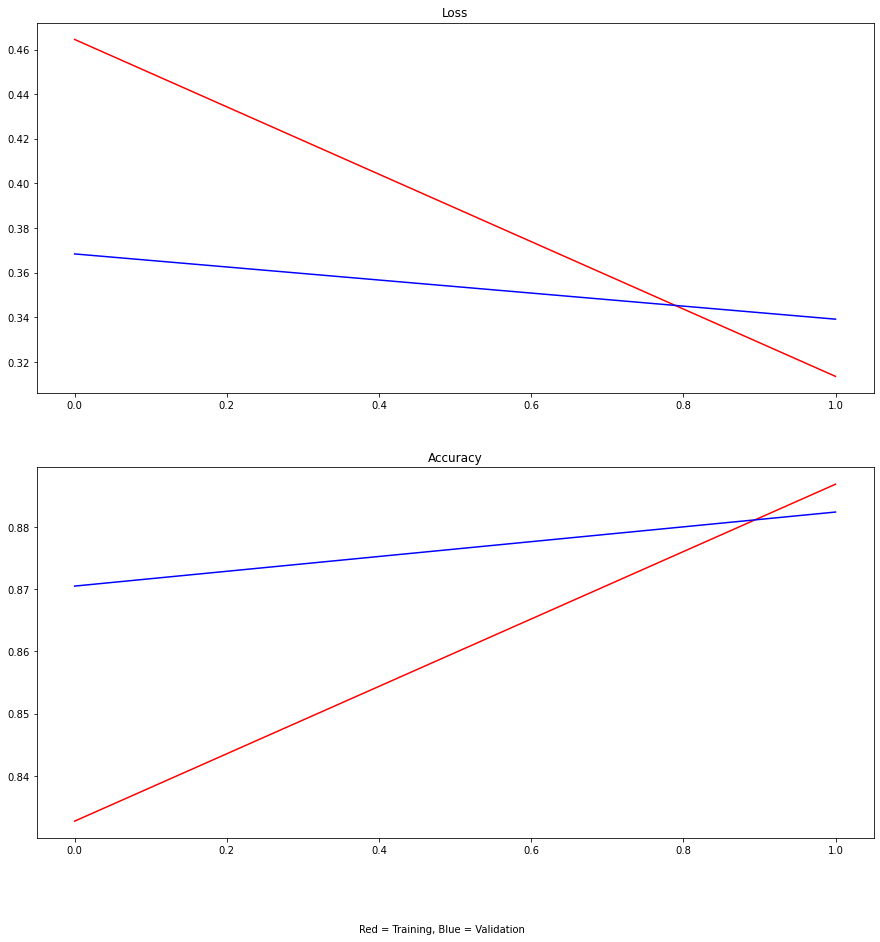

In [106]:
test_harness(tf.keras.datasets.fashion_mnist)

Our model performs well with no hyperparameter tuning. It starts to overfit at 1 epoch, but for the sake of testing the tuners we will leave the epcohs set to 4, for more data on tuner behaviour.

#### 3.12: Keras Tuner
Now keras tuner must be setup and tested. Keras tuner is capable of tuning a wide range of hyperparameters including the network topology, but we will use it for learning rate and momentum only, as this will be the focus of our tuner.

In [109]:
from kerastuner.tuners import RandomSearch
from kerastuner.tuners import BayesianOptimization
from kerastuner.tuners import Hyperband

#Keras Tuner Random Search
kt_hp_randomSearch = RandomSearch(
            build_model,
            objective='val_accuracy',
            max_trials=5,
            executions_per_trial=3,
            directory='Coursework 2',
            project_name='Fashion MNIST',
            overwrite=True
        )

#Keras Tuner bayesian method
kt_hp_bayesian = BayesianOptimization(
            build_model,
            objective='val_accuracy',
            max_trials=5,
            executions_per_trial=3,
            directory='Coursework 2',
            project_name='Fashion MNIST',
            overwrite=True
        )

#Hyperband
kt_hp_hyperband = Hyperband(
            build_model,
            objective='val_accuracy',
            max_epochs=5,
            executions_per_trial=3,
            directory='Coursework 2',
            project_name='Fashion MNIST',
            overwrite=True
        )

Next I will fit the network using the three hyparameter tuners from keras tuner.

Trial 5 Complete [00h 01m 13s]
val_accuracy: 0.8952962954839071

Best val_accuracy So Far: 0.8954629699389139
Total elapsed time: 00h 05m 29s
INFO:tensorflow:Oracle triggered exit
Epoch 1/4
1313/1313 [==============================] - 7s 5ms/step - loss: 0.2441 - accuracy: 0.9098 - val_loss: 0.3021 - val_accuracy: 0.8942
Epoch 2/4
1313/1313 [==============================] - 6s 5ms/step - loss: 0.2214 - accuracy: 0.9195 - val_loss: 0.3073 - val_accuracy: 0.8913
Epoch 3/4
1313/1313 [==============================] - 6s 5ms/step - loss: 0.2049 - accuracy: 0.9248 - val_loss: 0.2894 - val_accuracy: 0.8998
Epoch 4/4
1313/1313 [==============================] - 6s 5ms/step - loss: 0.1881 - accuracy: 0.9320 - val_loss: 0.3053 - val_accuracy: 0.8963


C:\Users\noahd\anaconda3\envs\tf-2-3\lib\site-packages\ipykernel_launcher.py:73: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


<Figure size 432x288 with 0 Axes>

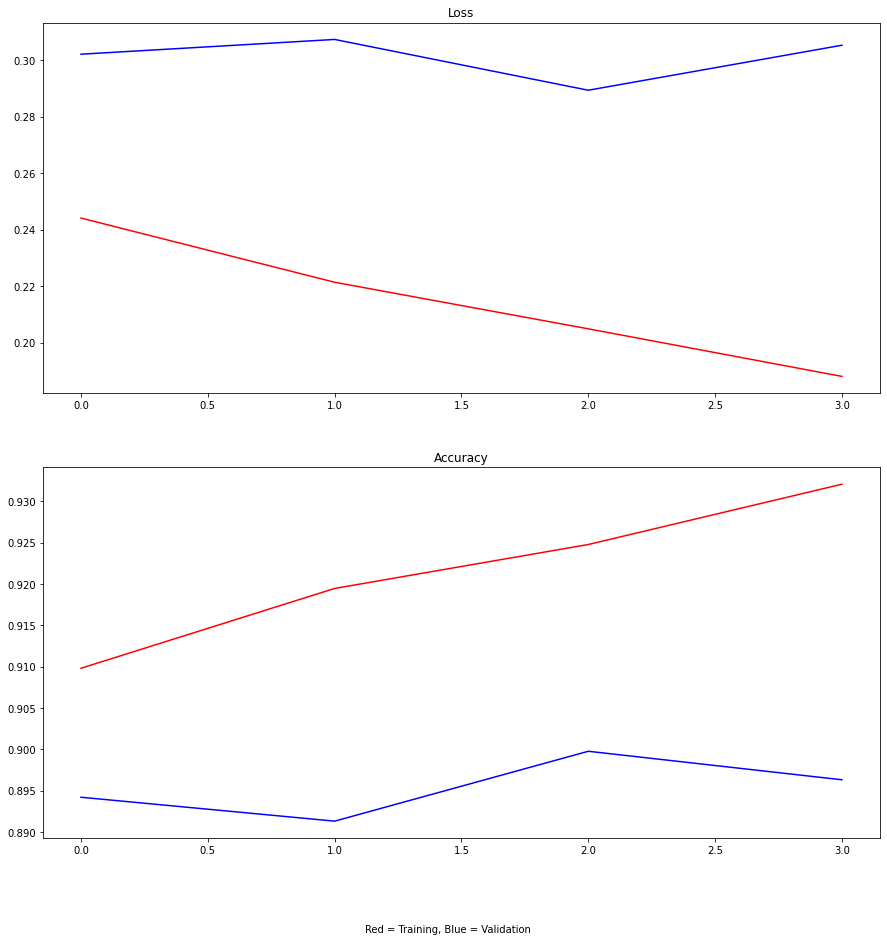

In [111]:
test_harness(tf.keras.datasets.fashion_mnist, kt_hp_bayesian)

Trial 5 Complete [00h 01m 15s]
val_accuracy: 0.7633888920148214

Best val_accuracy So Far: 0.9029074112574259
Total elapsed time: 00h 05m 27s
INFO:tensorflow:Oracle triggered exit
Epoch 1/4
1313/1313 [==============================] - 7s 5ms/step - loss: 0.2148 - accuracy: 0.9218 - val_loss: 0.2854 - val_accuracy: 0.8985
Epoch 2/4
1313/1313 [==============================] - 6s 5ms/step - loss: 0.1956 - accuracy: 0.9280 - val_loss: 0.2923 - val_accuracy: 0.8993
Epoch 3/4
1313/1313 [==============================] - 6s 5ms/step - loss: 0.1801 - accuracy: 0.9340 - val_loss: 0.2869 - val_accuracy: 0.9012
Epoch 4/4
1313/1313 [==============================] - 6s 5ms/step - loss: 0.1639 - accuracy: 0.9403 - val_loss: 0.3345 - val_accuracy: 0.8892


C:\Users\noahd\anaconda3\envs\tf-2-3\lib\site-packages\ipykernel_launcher.py:73: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


<Figure size 432x288 with 0 Axes>

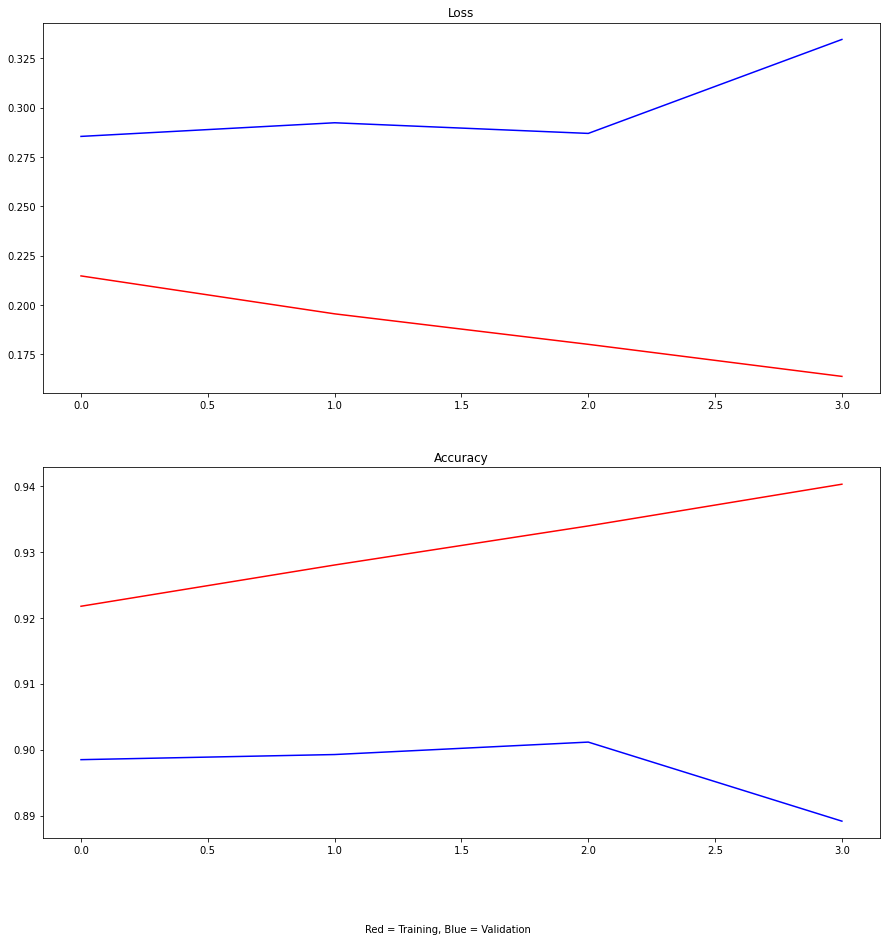

In [112]:
test_harness(tf.keras.datasets.fashion_mnist, kt_hp_randomSearch)

In [ ]:
test_harness(tf.keras.datasets.fashion_mnist, kt_hp_hyperband)

All the keras tuner models work, improving the performance of the basic network slightly, although they do all cause overfitting. This may be to do with keras tuner optimising the netoworks for best training performance.

### 3.2: Program Structure
I will try to make my tuner program compatible with keras tuners methods, even if the functionailty is slightly different. This is so I can re-use the same test harness code for working with my own tuner. I should try to create an object with the following methods: 
 - ".search(x, y, epochs=Int,validation_split=Float)" Initialises a new search using the passed build model argument.
 - ".tuner.get_best_models(num_models=int)" Returns the best performing model
 
 The program will only implement a choice method for simplicity.
 
 ### 3.3: Models
 #### Random Search
 

In [155]:
class RandomSearch:
    #Intialise with default perameters for max trails and executions per trial set to 3
    def __init__(self,
                build_model=None,
                max_trials=20,
                executions_per_trial=3,
                search_space_dic = {'momentum': {'min': 0.7, 
                                             'max': 0.9, 
                                             'steps': 0.1},
                                'learning_rate': {'min': 0.001, 
                                                 'max': 0.1, 
                                                 'steps': 0.001}}
                ):
    
        #Poperties
        self.build_model = build_model
        self.max_trials = max_trials
        self.executions_per_trial = executions_per_trial    
        self.search_space_dic = search_space_dic
        self.models = []
    
    #Generate all possible values to search through
    def map_search_space(self, search_space_dic):
        search_space_values = []
    
        m = search_space_dic['momentum']['min']
        while m <= search_space_dic['momentum']['max']:
        
            lr = search_space_dic['learning_rate']['min']
            while lr <= search_space_dic['learning_rate']['max']:
                search_space_values.append([m, lr])
                lr += search_space_dic['learning_rate']['steps']
            
            m += search_space_dic['momentum']['steps']
            
        return search_space_values
        
    
    #Search function initiates the search
    def search(self, x, y, epochs,validation_split):
        import random
        search_values = self.map_search_space(self.search_space_dic)
        
        #Inner loop executes model fitting for i < executions per trial, it then stores then best result in self.models
        #The outer loop iterates through j < max trails, where a random value pair for momentum an learning rate is selected
        j = 0
        while j <= self.max_trials:
            model_data = [] #Stores best model from each trial in the format [[model_obj], [validation accuracy]]
            parameter_choices = random.choices(search_values) # Choses a random parameter pair from all possible created
            
            i = 0
            while i <= self.executions_per_trial:
                temp_models = [[], []]
                temp_model[0][i] = build_model(none,
                                               parameters == {'momentum': parameter_choices[0],
                                                             'learning_rate' : parameter_choices[1]
                                                             })
                temp_history = temp_model[0][i].model.fit(x, y, epochs, validation_split, verbose = 0) #fits the model
                temp_model[1][i] = temp_history.history['val_accuracy'][-1]
                print(temp_model)
                
            #Stores the best attempt in "model_data"
            best_trial_index = temp_model[1].index(max(temp_model[1]))
            model_data.append([temp_model[0][best_trial_index]],[temp_model[1][best_trial_index]])
            print(model_data)
            
        return model_data


In [156]:
train_data, train_labels, test_data, test_labels = load_data(tf.keras.datasets.fashion_mnist)
test = RandomSearch(build_model=build_model)
test.search(train_data, train_labels, 3, 0.3)

NameError: name 'none' is not defined

## Citations
1. Keras Tuner; Keras Tuner Team; Version 1.02; 20th November 2020; https://keras-team.github.io/keras-tuner/ <a name="Keras-Tuner" />
2. Fashion MNIST